# Problem 1

## Part A

### Importing the Libraries 

In [52]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras 
from keras import layers
from keras import models
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split, KFold

### Importing the Data 

In [53]:
data = pd.read_csv('Advertising-Copy1.csv', index_col = 0)

### Splitting the Dataset into Training & Test Set

In [54]:
np.random.seed(1)
X = data.drop(columns = 'sales')
y = data['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=1)

In [55]:
print(f"Number of observations in training set: {len(X_train)}")
print(f"Number of observations in test set: {len(X_test)}")

Number of observations in training set: 175
Number of observations in test set: 25


### Feature Scaling

In [56]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [57]:
X_train = pd.DataFrame(X_train_sc, index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(X_test_sc, index = X_test.index, columns = X_test.columns)

### Training 4-Layer NN and Performing K-Fold CV 

In [58]:
def build_model(layer_size=100, dropout_rate = 0.5):
    np.random.seed(1)
    tf.random.set_seed(1)
    model = models.Sequential()
    model.add(layers.Dense(layer_size, activation='relu', input_shape=(n_cols,), name = 'Hidden_Layer_1'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(layer_size, activation='relu', name = 'Hidden_Layer_2'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(layer_size, activation='relu', name = 'Hidden_Layer_3'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(layer_size, activation='relu', name = 'Hidden_Layer_4'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, name="Output_Layer"))
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    return model

In [8]:
np.random.seed(1)
tf.random.set_seed(1)
k = 10
epochs = 250
kf = KFold(n_splits = k)
all_mae_histories_train = []
all_mae_histories_val = []

for train_index, val_index in kf.split(X_train, y_train):
    
    partial_train_data, val_data = X_train.iloc[train_index], X_train.iloc[val_index]
    partial_train_target, val_target = y_train.iloc[train_index], y_train.iloc[val_index]
    n_cols = partial_train_data.shape[1]
    
    model = build_model(100, 0.2)
    
    history = model.fit(partial_train_data, partial_train_target,
    batch_size = 25,
    epochs = epochs,
    validation_data = (val_data, val_target),
    verbose = 0)
    
    all_mae_histories_train.append(history.history['mae'])
    all_mae_histories_val.append(history.history['val_mae'])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmps2gx_29q.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmps2gx_29q.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### Building the History of Successive Mean K-fold Train and Validation scores

In [9]:
#Building the history of successive mean K-fold train scores
average_mae_history_train = [np.mean([x[i] for x in all_mae_histories_train]) for i in range(epochs)]
#Building the history of successive mean K-fold validation scores
average_mae_history_val = [np.mean([x[i] for x in all_mae_histories_val]) for i in range(epochs)]

### Plotting Performance 

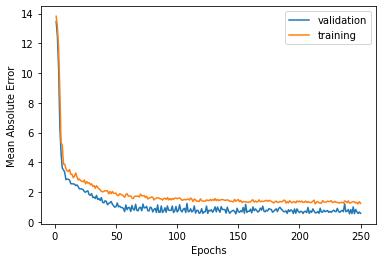

In [10]:
plt.plot(range(1, len(average_mae_history_val) + 1), average_mae_history_val,label='validation')
plt.plot(range(1, len(average_mae_history_train) + 1), average_mae_history_train,label='training')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

As we can see, the validation error starts to flatten out between 150 and 200 epochs. So we will choose 180 epochs as the optimal number of epochs for our network and retrain the model on the entire training set. 

### Retraining Model and Evaluating Out-of-Sample Performance 

In [68]:
model = build_model(100, 0.5)
fitted_model_hp = model.fit(X_train, y_train, batch_size = 25, epochs = 180, validation_split = 0.10, verbose = 0)

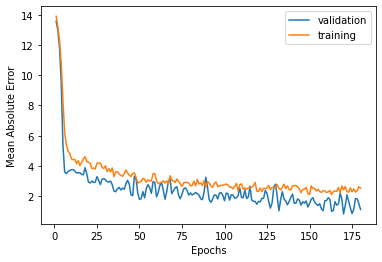

In [69]:
plt.plot(range(1, len(fitted_model_hp.history['val_mae']) + 1), fitted_model_hp.history['val_mae'],label='validation')
plt.plot(range(1, len(fitted_model_hp.history['mae']) + 1), fitted_model_hp.history['mae'],label='training')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

## Part B

### Testing Model Performance on Test Set

In [70]:
test_performance_model =  model.evaluate(X_test, y_test, verbose = 0)
print(test_performance_model[1]) #MAE

1.1950567960739136


The out of sample (test) MAE is 1.195. This error is higher than the MAE of the network with two hidden layers and no dropout layers from homework 1. The main reason for a lower error could be due to the dropout rate. Even if we have a 4 layer NN (more layers than the previous homework), our dropout rate is too high relative to the model complexity. Indeed, when I performed further experiments and reduced the dropout rate from 0.5 to 0.1, I ended up with an out-of-sample (test) MAE of 0.51. 

Regarding the model architecture, again, unfortunately, there is no magical formula to determine the right number of layers or the right size for each layer. Ideally, we evaluate an array of different architectures (on our validation set) in order to find the correct model size for our data. Trying out different layer sizes, I found 100 to yield the best results. In fact, I relied on the professor's notes and my own intuition, to include 100 neurons in each layer. This is because it is better to err on the side of having too many hidden units than too few. Moreover, we included a dropout layer with a rate of 0.5 after every layer, so having many hidden units will allow for a more effective regularization to take place since we will have a higher model capacity. This was the logic behind why I chose 100 as the number of units 

# Problem 2

## Part A

### Importing the Libraries 

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

### Creating the DataFrame for our Problem

In [15]:
df_btc = pd.read_csv('BTC-USD.csv')
df_btc = df_btc.iloc[1:,:]
df_btc['return_today'] = ((df_btc['Adj Close'] - df_btc['Open']) / df_btc['Open'])*100
df_btc['return_next_day'] = df_btc.return_today.shift(-1)


In [16]:
df_btc

,Date,Open,High,Low,Close,Adj Close,Volume,return_today,return_next_day
1,2015-04-26,226.410004,226.944000,214.873993,219.429993,219.429993,28943700,-3.082908,4.492111
2,2015-04-27,219.429001,233.304993,218.022995,229.285995,229.285995,38574000,4.492111,-1.360009
3,2015-04-28,228.968994,229.494995,223.069000,225.854996,225.854996,21469200,-1.360009,0.096190
4,2015-04-29,225.591003,227.039993,223.429993,225.807999,225.807999,18936500,0.096190,4.631075
5,2015-04-30,225.692993,239.563004,224.992996,236.145004,236.145004,33818600,4.631075,-1.636016
...,...,...,...,...,...,...,...,...,...
2528,2022-03-27,44505.355469,46827.546875,44437.292969,46820.492188,46820.492188,28160889722,5.201928,0.653866
2529,2022-03-28,46821.851563,48086.835938,46690.203125,47128.003906,47128.003906,36362175703,0.653866,0.775562
2530,2022-03-29,47100.437500,48022.289063,47100.437500,47465.730469,47465.730469,31397059069,0.775562,-0.830721
2531,2022-03-30,47456.898438,47655.148438,46746.210938,47062.664063,47062.664063,29333883962,-0.830721,-3.237151


In [17]:
df_btc = df_btc.copy()
for i in range(1,61):
    
    """
    For each index i, we will create a column that contains the return 
    for the previous i days. For example, for i = 1, we will create a 
    return-1D column that contains the previous day's returns. Similarly, 
    for i = 2, we will create a return-2D column that contains the return two
    days ago, and so on.
    
    """
    
    
    df_btc[f'return-{i}D'] = df_btc.return_today.shift(i)

In [18]:
df_btc

,Date,Open,High,Low,Close,Adj Close,Volume,return_today,return_next_day,return-1D,...,return-51D,return-52D,return-53D,return-54D,return-55D,return-56D,return-57D,return-58D,return-59D,return-60D
1,2015-04-26,226.410004,226.944000,214.873993,219.429993,219.429993,28943700,-3.082908,4.492111,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-04-27,219.429001,233.304993,218.022995,229.285995,229.285995,38574000,4.492111,-1.360009,-3.082908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-04-28,228.968994,229.494995,223.069000,225.854996,225.854996,21469200,-1.360009,0.096190,4.492111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-04-29,225.591003,227.039993,223.429993,225.807999,225.807999,18936500,0.096190,4.631075,-1.360009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-04-30,225.692993,239.563004,224.992996,236.145004,236.145004,33818600,4.631075,-1.636016,0.096190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,2022-03-27,44505.355469,46827.546875,44437.292969,46820.492188,46820.492188,28160889722,5.201928,0.653866,0.340404,...,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534,0.804398,-0.266287
2529,2022-03-28,46821.851563,48086.835938,46690.203125,47128.003906,47128.003906,36362175703,0.653866,0.775562,5.201928,...,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534,0.804398
2530,2022-03-29,47100.437500,48022.289063,47100.437500,47465.730469,47465.730469,31397059069,0.775562,-0.830721,0.653866,...,2.343837,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534
2531,2022-03-30,47456.898438,47655.148438,46746.210938,47062.664063,47062.664063,29333883962,-0.830721,-3.237151,0.775562,...,3.380365,2.343837,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157


In [19]:
df_btc.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [20]:
df_btc 

,Date,return_today,return_next_day,return-1D,return-2D,return-3D,return-4D,return-5D,return-6D,return-7D,...,return-51D,return-52D,return-53D,return-54D,return-55D,return-56D,return-57D,return-58D,return-59D,return-60D
1,2015-04-26,-3.082908,4.492111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-04-27,4.492111,-1.360009,-3.082908,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-04-28,-1.360009,0.096190,4.492111,-3.082908,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-04-29,0.096190,4.631075,-1.360009,4.492111,-3.082908,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-04-30,4.631075,-1.636016,0.096190,-1.360009,4.492111,-3.082908,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,2022-03-27,5.201928,0.653866,0.340404,0.873849,2.504931,1.247695,3.127769,-0.407642,-2.236432,...,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534,0.804398,-0.266287
2529,2022-03-28,0.653866,0.775562,5.201928,0.340404,0.873849,2.504931,1.247695,3.127769,-0.407642,...,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534,0.804398
2530,2022-03-29,0.775562,-0.830721,0.653866,5.201928,0.340404,0.873849,2.504931,1.247695,3.127769,...,2.343837,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534
2531,2022-03-30,-0.830721,-3.237151,0.775562,0.653866,5.201928,0.340404,0.873849,2.504931,1.247695,...,3.380365,2.343837,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157


In [21]:
df_btc_test = df_btc.iloc[-500:,:]
df_btc_train = df_btc.iloc[:2032,:]

In [22]:
df_btc_test

,Date,return_today,return_next_day,return-1D,return-2D,return-3D,return-4D,return-5D,return-6D,return-7D,...,return-51D,return-52D,return-53D,return-54D,return-55D,return-56D,return-57D,return-58D,return-59D,return-60D
2033,2020-11-17,5.751724,0.900044,4.766573,-0.700465,-1.530046,0.254160,3.662404,2.684148,-0.270332,...,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717,-4.322535,-1.420336,1.468789,-0.066056
2034,2020-11-18,0.900044,0.074301,5.751724,4.766573,-0.700465,-1.530046,0.254160,3.662404,2.684148,...,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717,-4.322535,-1.420336,1.468789
2035,2020-11-19,0.074301,4.513816,0.900044,5.751724,4.766573,-0.700465,-1.530046,0.254160,3.662404,...,1.260454,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717,-4.322535,-1.420336
2036,2020-11-20,4.513816,0.112323,0.074301,0.900044,5.751724,4.766573,-0.700465,-1.530046,0.254160,...,-0.547589,1.260454,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717,-4.322535
2037,2020-11-21,0.112323,-1.460289,4.513816,0.074301,0.900044,5.751724,4.766573,-0.700465,-1.530046,...,-1.628519,-0.547589,1.260454,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,2022-03-27,5.201928,0.653866,0.340404,0.873849,2.504931,1.247695,3.127769,-0.407642,-2.236432,...,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534,0.804398,-0.266287
2529,2022-03-28,0.653866,0.775562,5.201928,0.340404,0.873849,2.504931,1.247695,3.127769,-0.407642,...,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534,0.804398
2530,2022-03-29,0.775562,-0.830721,0.653866,5.201928,0.340404,0.873849,2.504931,1.247695,3.127769,...,2.343837,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534
2531,2022-03-30,-0.830721,-3.237151,0.775562,0.653866,5.201928,0.340404,0.873849,2.504931,1.247695,...,3.380365,2.343837,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157


In [23]:
df_btc_train

,Date,return_today,return_next_day,return-1D,return-2D,return-3D,return-4D,return-5D,return-6D,return-7D,...,return-51D,return-52D,return-53D,return-54D,return-55D,return-56D,return-57D,return-58D,return-59D,return-60D
1,2015-04-26,-3.082908,4.492111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-04-27,4.492111,-1.360009,-3.082908,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-04-28,-1.360009,0.096190,4.492111,-3.082908,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-04-29,0.096190,4.631075,-1.360009,4.492111,-3.082908,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-04-30,4.631075,-1.636016,0.096190,-1.360009,4.492111,-3.082908,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028,2020-11-12,3.662404,0.254160,2.684148,-0.270332,-0.951448,4.353675,-4.703408,-0.088889,10.231658,...,0.753717,-4.322535,-1.420336,1.468789,-0.066056,-0.221099,1.640558,1.116305,3.408971,-1.230756
2029,2020-11-13,0.254160,-1.530046,3.662404,2.684148,-0.270332,-0.951448,4.353675,-4.703408,-0.088889,...,-2.746010,0.753717,-4.322535,-1.420336,1.468789,-0.066056,-0.221099,1.640558,1.116305,3.408971
2030,2020-11-14,-1.530046,-0.700465,0.254160,3.662404,2.684148,-0.270332,-0.951448,4.353675,-4.703408,...,4.988691,-2.746010,0.753717,-4.322535,-1.420336,1.468789,-0.066056,-0.221099,1.640558,1.116305
2031,2020-11-15,-0.700465,4.766573,-1.530046,0.254160,3.662404,2.684148,-0.270332,-0.951448,4.353675,...,-0.635553,4.988691,-2.746010,0.753717,-4.322535,-1.420336,1.468789,-0.066056,-0.221099,1.640558


### Dropping NA's 

In [24]:
df_btc_train = df_btc_train.dropna()
df_btc_test = df_btc_test.dropna()

In [25]:
df_btc_train

,Date,return_today,return_next_day,return-1D,return-2D,return-3D,return-4D,return-5D,return-6D,return-7D,...,return-51D,return-52D,return-53D,return-54D,return-55D,return-56D,return-57D,return-58D,return-59D,return-60D
61,2015-06-25,1.012623,0.408068,-1.542070,-1.065496,1.238277,-0.471647,0.278905,-1.781618,-0.168782,...,-1.143387,-0.556673,2.332253,1.114306,-1.636016,4.631075,0.096190,-1.360009,4.492111,-3.082908
62,2015-06-26,0.408068,3.055241,1.012623,-1.542070,-1.065496,1.238277,-0.471647,0.278905,-1.781618,...,-2.737364,-1.143387,-0.556673,2.332253,1.114306,-1.636016,4.631075,0.096190,-1.360009,4.492111
63,2015-06-27,3.055241,-0.774641,0.408068,1.012623,-1.542070,-1.065496,1.238277,-0.471647,0.278905,...,3.340560,-2.737364,-1.143387,-0.556673,2.332253,1.114306,-1.636016,4.631075,0.096190,-1.360009
64,2015-06-28,-0.774641,3.354362,3.055241,0.408068,1.012623,-1.542070,-1.065496,1.238277,-0.471647,...,2.807293,3.340560,-2.737364,-1.143387,-0.556673,2.332253,1.114306,-1.636016,4.631075,0.096190
65,2015-06-29,3.354362,2.348301,-0.774641,3.055241,0.408068,1.012623,-1.542070,-1.065496,1.238277,...,-0.794603,2.807293,3.340560,-2.737364,-1.143387,-0.556673,2.332253,1.114306,-1.636016,4.631075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028,2020-11-12,3.662404,0.254160,2.684148,-0.270332,-0.951448,4.353675,-4.703408,-0.088889,10.231658,...,0.753717,-4.322535,-1.420336,1.468789,-0.066056,-0.221099,1.640558,1.116305,3.408971,-1.230756
2029,2020-11-13,0.254160,-1.530046,3.662404,2.684148,-0.270332,-0.951448,4.353675,-4.703408,-0.088889,...,-2.746010,0.753717,-4.322535,-1.420336,1.468789,-0.066056,-0.221099,1.640558,1.116305,3.408971
2030,2020-11-14,-1.530046,-0.700465,0.254160,3.662404,2.684148,-0.270332,-0.951448,4.353675,-4.703408,...,4.988691,-2.746010,0.753717,-4.322535,-1.420336,1.468789,-0.066056,-0.221099,1.640558,1.116305
2031,2020-11-15,-0.700465,4.766573,-1.530046,0.254160,3.662404,2.684148,-0.270332,-0.951448,4.353675,...,-0.635553,4.988691,-2.746010,0.753717,-4.322535,-1.420336,1.468789,-0.066056,-0.221099,1.640558


In [26]:
df_btc_test

,Date,return_today,return_next_day,return-1D,return-2D,return-3D,return-4D,return-5D,return-6D,return-7D,...,return-51D,return-52D,return-53D,return-54D,return-55D,return-56D,return-57D,return-58D,return-59D,return-60D
2033,2020-11-17,5.751724,0.900044,4.766573,-0.700465,-1.530046,0.254160,3.662404,2.684148,-0.270332,...,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717,-4.322535,-1.420336,1.468789,-0.066056
2034,2020-11-18,0.900044,0.074301,5.751724,4.766573,-0.700465,-1.530046,0.254160,3.662404,2.684148,...,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717,-4.322535,-1.420336,1.468789
2035,2020-11-19,0.074301,4.513816,0.900044,5.751724,4.766573,-0.700465,-1.530046,0.254160,3.662404,...,1.260454,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717,-4.322535,-1.420336
2036,2020-11-20,4.513816,0.112323,0.074301,0.900044,5.751724,4.766573,-0.700465,-1.530046,0.254160,...,-0.547589,1.260454,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717,-4.322535
2037,2020-11-21,0.112323,-1.460289,4.513816,0.074301,0.900044,5.751724,4.766573,-0.700465,-1.530046,...,-1.628519,-0.547589,1.260454,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,2022-03-26,0.340404,5.201928,0.873849,2.504931,1.247695,3.127769,-0.407642,-2.236432,0.947499,...,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534,0.804398,-0.266287,0.816262
2528,2022-03-27,5.201928,0.653866,0.340404,0.873849,2.504931,1.247695,3.127769,-0.407642,-2.236432,...,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534,0.804398,-0.266287
2529,2022-03-28,0.653866,0.775562,5.201928,0.340404,0.873849,2.504931,1.247695,3.127769,-0.407642,...,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534,0.804398
2530,2022-03-29,0.775562,-0.830721,0.653866,5.201928,0.340404,0.873849,2.504931,1.247695,3.127769,...,2.343837,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534


### Creating Training & Testing Data

In [27]:
X_train = df_btc_train.iloc[:, 3:-1] #Previous 60 days' returns (including today's)
y_train = df_btc_train.iloc[:, 2] #Next Day's Return
X_test = df_btc_test.iloc[:, 3:-1]
y_test = df_btc_test.iloc[:, 2]

In [28]:
X_train.insert(0, 'return_today', df_btc_train['return_today'])
X_test.insert(0, 'return_today', df_btc_test['return_today'])

In [29]:
X_train

,return_today,return-1D,return-2D,return-3D,return-4D,return-5D,return-6D,return-7D,return-8D,return-9D,...,return-50D,return-51D,return-52D,return-53D,return-54D,return-55D,return-56D,return-57D,return-58D,return-59D
61,1.012623,-1.542070,-1.065496,1.238277,-0.471647,0.278905,-1.781618,-0.168782,-0.613580,5.967945,...,-2.737364,-1.143387,-0.556673,2.332253,1.114306,-1.636016,4.631075,0.096190,-1.360009,4.492111
62,0.408068,1.012623,-1.542070,-1.065496,1.238277,-0.471647,0.278905,-1.781618,-0.168782,-0.613580,...,3.340560,-2.737364,-1.143387,-0.556673,2.332253,1.114306,-1.636016,4.631075,0.096190,-1.360009
63,3.055241,0.408068,1.012623,-1.542070,-1.065496,1.238277,-0.471647,0.278905,-1.781618,-0.168782,...,2.807293,3.340560,-2.737364,-1.143387,-0.556673,2.332253,1.114306,-1.636016,4.631075,0.096190
64,-0.774641,3.055241,0.408068,1.012623,-1.542070,-1.065496,1.238277,-0.471647,0.278905,-1.781618,...,-0.794603,2.807293,3.340560,-2.737364,-1.143387,-0.556673,2.332253,1.114306,-1.636016,4.631075
65,3.354362,-0.774641,3.055241,0.408068,1.012623,-1.542070,-1.065496,1.238277,-0.471647,0.278905,...,-0.592812,-0.794603,2.807293,3.340560,-2.737364,-1.143387,-0.556673,2.332253,1.114306,-1.636016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028,3.662404,2.684148,-0.270332,-0.951448,4.353675,-4.703408,-0.088889,10.231658,1.313350,2.950821,...,-2.746010,0.753717,-4.322535,-1.420336,1.468789,-0.066056,-0.221099,1.640558,1.116305,3.408971
2029,0.254160,3.662404,2.684148,-0.270332,-0.951448,4.353675,-4.703408,-0.088889,10.231658,1.313350,...,4.988691,-2.746010,0.753717,-4.322535,-1.420336,1.468789,-0.066056,-0.221099,1.640558,1.116305
2030,-1.530046,0.254160,3.662404,2.684148,-0.270332,-0.951448,4.353675,-4.703408,-0.088889,10.231658,...,-0.635553,4.988691,-2.746010,0.753717,-4.322535,-1.420336,1.468789,-0.066056,-0.221099,1.640558
2031,-0.700465,-1.530046,0.254160,3.662404,2.684148,-0.270332,-0.951448,4.353675,-4.703408,-0.088889,...,0.515619,-0.635553,4.988691,-2.746010,0.753717,-4.322535,-1.420336,1.468789,-0.066056,-0.221099


In [30]:
X_test

,return_today,return-1D,return-2D,return-3D,return-4D,return-5D,return-6D,return-7D,return-8D,return-9D,...,return-50D,return-51D,return-52D,return-53D,return-54D,return-55D,return-56D,return-57D,return-58D,return-59D
2033,5.751724,4.766573,-0.700465,-1.530046,0.254160,3.662404,2.684148,-0.270332,-0.951448,4.353675,...,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717,-4.322535,-1.420336,1.468789
2034,0.900044,5.751724,4.766573,-0.700465,-1.530046,0.254160,3.662404,2.684148,-0.270332,-0.951448,...,1.260454,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717,-4.322535,-1.420336
2035,0.074301,0.900044,5.751724,4.766573,-0.700465,-1.530046,0.254160,3.662404,2.684148,-0.270332,...,-0.547589,1.260454,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717,-4.322535
2036,4.513816,0.074301,0.900044,5.751724,4.766573,-0.700465,-1.530046,0.254160,3.662404,2.684148,...,-1.628519,-0.547589,1.260454,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010,0.753717
2037,0.112323,4.513816,0.074301,0.900044,5.751724,4.766573,-0.700465,-1.530046,0.254160,3.662404,...,-0.412876,-1.628519,-0.547589,1.260454,-0.621354,0.264048,0.515619,-0.635553,4.988691,-2.746010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,0.340404,0.873849,2.504931,1.247695,3.127769,-0.407642,-2.236432,0.947499,2.091390,-0.460527,...,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534,0.804398,-0.266287
2528,5.201928,0.340404,0.873849,2.504931,1.247695,3.127769,-0.407642,-2.236432,0.947499,2.091390,...,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534,0.804398
2529,0.653866,5.201928,0.340404,0.873849,2.504931,1.247695,3.127769,-0.407642,-2.236432,0.947499,...,2.343837,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157,1.766534
2530,0.775562,0.653866,5.201928,0.340404,0.873849,2.504931,1.247695,3.127769,-0.407642,-2.236432,...,3.380365,2.343837,-0.145336,11.713850,0.567866,-4.621990,0.679563,1.484282,-0.614167,0.946157


In [31]:
y_train

61      0.408068
62      3.055241
63     -0.774641
64      3.354362
65      2.348301
          ...   
2028    0.254160
2029   -1.530046
2030   -0.700465
2031    4.766573
2032    5.751724
Name: return_next_day, Length: 1972, dtype: float64

In [32]:
y_test

2033    0.900044
2034    0.074301
2035    4.513816
2036    0.112323
2037   -1.460289
          ...   
2527    5.201928
2528    0.653866
2529    0.775562
2530   -0.830721
2531   -3.237151
Name: return_next_day, Length: 499, dtype: float64

In [33]:
X_train = X_train.to_numpy().reshape((X_train.shape[0], X_train.shape[1], 1))

In [34]:
X_test = X_test.to_numpy().reshape((X_test.shape[0], X_test.shape[1], 1))

### Building the CNN

In [35]:
cnn = tf.keras.models.Sequential()

### Convolution Layer

In [36]:
cnn.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(60,1)))

### Pooling Layer

In [37]:
cnn.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))

### Adding Another Convolution Layer

In [38]:
cnn.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=2))

### Flattening

In [39]:
cnn.add(tf.keras.layers.Flatten())

### Full Connection 

In [40]:
cnn.add(tf.keras.layers.Dense(units=200, activation='relu'))

### Output Layer

In [41]:
cnn.add(tf.keras.layers.Dense(units=1))

### Training the CNN

In [42]:
cnn.compile(optimizer = 'adam', loss = 'mae')

In [43]:
history = cnn.fit(X_train, y_train, epochs = 25, verbose=0)


## Part B

### Predictions

In [44]:
result = cnn.predict(X_test)

In [45]:
result = result.reshape(499,)

In [46]:
final_result_df = pd.DataFrame({"Date":df_btc_test['Date'], "Next Day Returns Actual": df_btc_test['return_next_day'],
                               "Next Day Returns Predicted":result })

In [47]:
final_result_df

,Date,Next Day Returns Actual,Next Day Returns Predicted
2033,2020-11-17,0.900044,-0.532499
2034,2020-11-18,0.074301,0.145025
2035,2020-11-19,4.513816,-0.659567
2036,2020-11-20,0.112323,0.420230
2037,2020-11-21,-1.460289,-0.452296
...,...,...,...
2527,2022-03-26,5.201928,0.272810
2528,2022-03-27,0.653866,0.005955
2529,2022-03-28,0.775562,0.181575
2530,2022-03-29,-0.830721,-0.490179


### Evaluating Performance 

In [48]:
from sklearn.metrics import mean_absolute_error

In [49]:
test_mae = mean_absolute_error(y_test, result)

In [50]:
test_mae

3.20973410475897

The Test MAE is 3.21%. Unfortunately, this is an indication that our model was not able to effectively capture signal. Financial returns are indeed very hard to predict (otherwise we would all be billionaires) and considering the fact that we are trying to predict the returns of such a volatile financial asset as Bitcoin, our basic CNN model is going to find it very hard to extract signal amidst the noiseness in the data. Nevertheless, this is the lowest test MAE achieved after I experimented with several architectures.

## Part C

For my architecture, I decided to use two convolution layers (each with a pooling layer). The first convolution layer has 64 filters with a kernel size of 3. The reason I chose 64 filters on a dataset with 60 features is because with 64 filters, we can extract some meaningful patterns present in the data. The kernel size chosen is 3 by 3. This is because the number of parameters grows quadratically with kernel size, which makes big convolution kernels not cost efficient enough. Furthermore, we use an odd number for kernel size since for image data, all the previous layer pixels would be symmetrical around the output pixel. Without this symmetry, we will have to account for distortions across the layers. This can apply for a time-series dataset as well. For pooling, I chose a pool size of 2 with stride 2 since this is the most common pool size and stride used in the prior literature, and has been tried and tested across a variety of applications before, including those similar to our problem. 

I also added a second convolution layer, this time with 128 filters and a kernel size of three. I added a second layer because the stacking of convolutional layers allows a hierarchical decomposition of the input.
With a higher number of filters in the second layer, this will allow our network to learn to extract even more low-level features from the data. Finally, for the fully connected layer, I decided to include 200 units as it yielded the best results after multiple experiments. 